<a href="https://colab.research.google.com/github/SauravMaheshkar/medical/blob/main/fMRI/Voxel_to_CLIPvoxel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contributors (in no particular order):
**This list is being updated, feel free to add your contributions**
- Paul Scotti (@humanscotti / @pscotti) (https://github.com/PaulScotti): Project lead
- Aidan Dempster (@veldrovive): Large parts of Voxel-to-CLIP code were modified his work here: https://github.com/Veldrovive/open_clip (in particular check out his networks for future use: https://github.com/Veldrovive/open_clip/blob/main/src/open_clip/model.py)
- Jimmie Goode (@jimgoo) (https://github.com/jimgoo): fixed parts of voxel-to-clip involving l2 norming which greatly improved retrieval evaluations
- Tanishq Abraham (@ilovescience / @iScienceLuvr) (https://github.com/tmabraham): Overall help with many aspects of project
- Ethan Cohen (@ethan_cohen): Initial explorations of integrating voxels with Dalle2 diffusion prior 
- Nev (@nev): Various explorations including reconstructions via feedforward VQGAN and KNN-based LAION-5B prediction using CLIP embeddings
- Nathalie Verlinde: Projected NSD images to StyleGAN-XL space
- @Atom_101: Helping tidy up this notebook, added backwards / forwards retrieval

# Import packages & functions

In [ ]:
import os
import sys
import math
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip
import pandas as pd
from collections import OrderedDict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

GLOBAL_SEED = 0

def seed_everything(seed=GLOBAL_SEED):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(GLOBAL_SEED)

device: cuda


In [ ]:
# CLIP utilities
import clip
class Clipper(torch.nn.Module):
    def __init__(self, clip_variant):
        super().__init__()
        print(clip_variant, device)
        clip_model, _ = clip.load(clip_variant, device=device)
        clip_model.eval() # dont want to train model
        for param in clip_model.parameters():
            param.requires_grad = False # dont need to calculate gradients
            
        self.clip = clip_model
        self.mean = np.array([0.48145466, 0.4578275, 0.40821073])
        self.std = np.array([0.26862954, 0.26130258, 0.27577711])
        self.normalize = transforms.Normalize(self.mean, self.std)
        self.denormalize = transforms.Normalize((-self.mean / self.std).tolist(), (1.0 / self.std).tolist())
        self.clip_size = (224,224)

    def embed_image(self, image):
        """Expects images in -1 to 1 range"""
        clip_emb = nn.functional.interpolate(image.to(device), self.clip_size, mode="area")
        clip_emb = self.normalize(0.5*clip_emb + 0.5).clamp(0,1)
        clip_emb = self.clip.encode_image(self.normalize(clip_emb))
        clip_emb = torch.clamp(clip_emb, -1.5, 1.5)
        clip_emb = nn.functional.normalize(clip_emb, dim=-1)
        return clip_emb

    def embed_text(self, text_samples):
        clip_text = clip.tokenize(text_samples).to(device)
        clip_text = self.clip.encode_text(clip_text)
        clip_text = torch.clamp(clip_text, -1.5, 1.5)
        clip_text = nn.functional.normalize(clip_text, dim=-1)
        return clip_text
    
    def embed_curated_annotations(self, annots):
        for i,b in enumerate(annots):
            t = ''
            while t == '':
                rand = torch.randint(5,(1,1))[0][0]
                t = b[0,rand]
            if i==0:
                txt = np.array(t)
            else:
                txt = np.vstack((txt,t))
        txt = txt.flatten()
        return self.embed_text(txt)

In [ ]:
# custom functions
def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))
def torch_to_Image(x):
    return transforms.ToPILImage()(x)
def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5
def torch_to_matplotlib(x,device=device):
    if torch.mean(x)>10:
        x = (x.permute(0, 2, 3, 1)).clamp(0, 255).to(torch.uint8)
    else:
        x = (x.permute(0, 2, 3, 1) * 255).clamp(0, 255).to(torch.uint8)
    if device=='cpu':
        return x[0]
    else:
        return x.cpu().numpy()[0]
def pairwise_cosine_similarity(A, B, dim=1, eps=1e-8):
    #https://stackoverflow.com/questions/67199317/pytorch-cosine-similarity-nxn-elements
    numerator = A @ B.T
    A_l2 = torch.mul(A, A).sum(axis=dim)
    B_l2 = torch.mul(B, B).sum(axis=dim)
    denominator = torch.max(torch.sqrt(torch.outer(A_l2, B_l2)), torch.tensor(eps))
    return torch.div(numerator, denominator)
def batchwise_cosine_similarity(Z,B):
    # https://www.h4pz.co/blog/2021/4/2/batch-cosine-similarity-in-pytorch-or-numpy-jax-cupy-etc
    B = B.T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity
def get_non_diagonals(a):
    a = torch.triu(a,diagonal=1)+torch.tril(a,diagonal=-1)
    # make diagonals -1
    a=a.fill_diagonal_(-1)
    return a
def topk(similarities,labels,k=5):
    if k > similarities.shape[0]:
        k = similarities.shape[0]
    topsum=0
    for i in range(k):
        topsum += torch.sum(torch.argsort(similarities,axis=1)[:,-(i+1)] == labels)/len(labels)
    return topsum

In [ ]:
# setup multi-gpu Data Distributed Processing (ddp) if available
%run ddp_config.py
using_ddp = ddp_test()
print("using_ddp:",using_ddp)

NOT using distributed parallel processing!
using_ddp: False


In [ ]:
# if full_training is True, use large batches and the entire training dataset 
full_training = True
print('full_training:',full_training)

full_training: True


## Which pretrained model are you using for voxel alignment to embedding space? 

In [ ]:
model_name = 'clip_image_vit' # CLIP ViT-L/14 image embeddings

# model_name = 'clip_text_vit' # CLIP ViT-L/14 text embeddings

# model_name = 'clip_image_resnet' # CLIP basic ResNet image embeddings

print(f"Using model: {model_name}")
    
if "resnet" in model_name: 
    clip_extractor = Clipper("RN50")
else:
    clip_extractor = Clipper("ViT-L/14")
    
if "text" in model_name: 
    # load COCO annotations curated in the same way as the mind_reader (Lin Sprague Singh) preprint
    f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
    subj01_order = f['subj01'][:]
    f.close()
    annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
    subj01_annots = annots[subj01_order]
    
    image_var = 'trial' 
else:
    image_var = 'images'
print("image_var =", image_var)

Using model: clip_image_vit
ViT-L/14 cuda
image_var = images


# Load data

NSD webdatasets for subjects 1, 2, and 3 are publicly available here: 

https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main/webdataset

In [ ]:
# image augmentation just for the CLIP image model that will be more semantic-focused
img_augment = transforms.Compose([
                    transforms.RandomCrop(size=(140,140)),
                    transforms.Resize(size=(224,224)),
                    transforms.RandomHorizontalFlip(p=.5),
                    transforms.ColorJitter(.4,.4,.2,.1),
                    transforms.RandomGrayscale(p=.2),
                ])

if not full_training: 
    num_devices = 1
    num_workers = 1
    print("num_workers",num_workers)
    batch_size = 16
    print("batch_size",batch_size)
    num_samples = 500 
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..1}.tar"
else:
    num_devices = torch.cuda.device_count()
    print("num_devices",num_devices)
    num_workers = num_devices
    print("num_workers",num_workers)
    batch_size = 300
    print("batch_size",batch_size)
    num_samples = 24983 # see metadata.json in webdataset_split folder
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"

train_data = wds.DataPipeline([wds.ResampledShards(train_url),
                    wds.tarfile_to_samples(),
                    wds.shuffle(500,initial=500),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", image_var),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
train_dl = wds.WebLoader(train_data, num_workers=num_workers,
                         batch_size=None, shuffle=False, persistent_workers=True)

# Validation #
num_samples = 492
num_batches = math.ceil(num_samples / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches",num_worker_batches)

url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
val_data = wds.DataPipeline([wds.ResampledShards(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.to_tuple("voxels", image_var),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

num_devices 1
num_workers 1
batch_size 300
global_batch_size 300
num_worker_batches 83
validation: num_worker_batches 2


In [ ]:
# check that your data loaders are working
for train_i, (voxel, img_input) in enumerate(train_dl):
    print("idx",train_i)
    print("voxel.shape",voxel.shape)
    if "text" in model_name:
        emb = clip_extractor.embed_curated_annotations(subj01_annots[img_input])
    else:
        emb = clip_extractor.embed_image(img_input)
    print("emb.shape",emb.shape)
    out_dim = emb.shape[1]
    print("out_dim", out_dim)
    break

idx 0
voxel.shape torch.Size([300, 15724])
emb.shape torch.Size([300, 768])
out_dim 768


# Initialize model

In [ ]:
class BrainNetwork(nn.Module):
    def __init__(self,
                 out_dim,
                 input_size=15724,
                 h1=4096,
                 h2=2048,
                 h3=1024,
                 pdrop=0.1,
    ):
        super().__init__()
        
        self.mlp = nn.Sequential(
            #torch.nn.BatchNorm1d(input_size),
            nn.Linear(input_size, h1),
            nn.ReLU(),
            nn.Dropout(pdrop),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(pdrop),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Dropout(pdrop),
            nn.Linear(h3, out_dim),
        )
        
    def forward(self, x):
        return self.mlp(x)

brain_net = BrainNetwork(out_dim) 

In [ ]:
if using_ddp:
    brain_net0 = brain_net.to(local_rank)
    brain_net = DDP(brain_net0, device_ids=[local_rank])
else:
    brain_net = brain_net.to(device)

# test out that the neural network can run without error:
with torch.cuda.amp.autocast():
    out = brain_net(voxel.to(device))
    print(out.shape)

torch.Size([300, 768])


# Start model training

In [ ]:
if using_ddp:
    num_epochs = 1000 # basically until the time limit on my slurm job runs out
else:
    num_epochs = 5

initial_learning_rate = 3e-5
optimizer = torch.optim.AdamW(brain_net.parameters(), lr=initial_learning_rate)
# optimizer = torch.optim.SGD(brain_net.parameters(), lr=initial_learning_rate, momentum=0.95)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-8, patience=10) 

# loss function
nce = InfoNCE()

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(f"num_epochs:{num_epochs} batch_size:{batch_size} lr:{initial_learning_rate}")

if full_training:
    print(f"Will be saving model checkpoints to checkpoints/{model_name}_subj01_epoch#.pth")
else:
    print(f"Warning: not saving model checkpoints")

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

epoch = 0
train_losses = []; val_losses = []
train_topk = []; val_topk = []
lrs = []
epoch_logs = []

pbar = tqdm(range(epoch,num_epochs),ncols=250)
for epoch in pbar:
    brain_net.train()
    similarities = []
    for train_i, (voxel, img_input) in enumerate(train_dl):
        optimizer.zero_grad()
        
        voxel = voxel.to(device)
        
        with torch.cuda.amp.autocast():
            if image_var=='images': # using images
                emb = clip_extractor.embed_image(img_input)
            else: # using text captions of the images 
                emb = clip_extractor.embed_curated_annotations(subj01_annots[img_input])

            emb_ = brain_net(voxel)
            
            if torch.any(torch.isnan(emb_)):
                raise ValueError("NaN found...")
                
            emb_ = nn.functional.normalize(emb_,dim=-1) # l2 normalization on the embeddings
            
            labels = torch.arange(len(emb)).to(device)
            loss = nce(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1))
            
            similarities = batchwise_cosine_similarity(emb,emb_)

            percent_correct = topk(similarities,labels,k=1)
            
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_topk.append(percent_correct.item())
        
    brain_net.eval()    
    for val_i, (val_voxel, val_img_input) in enumerate(val_dl):
        with torch.no_grad(): 
            val_voxel = val_voxel.to(device)
            
            with torch.cuda.amp.autocast():
                if image_var=='images': # using images
                    val_emb = clip_extractor.embed_image(val_img_input)
                else: # using text captions of the images 
                    val_emb = clip_extractor.embed_curated_annotations(subj01_annots[val_img_input])

                val_emb_ = brain_net(val_voxel)
                val_emb_ = nn.functional.normalize(val_emb_,dim=-1) # l2 normalization on the embeddings
            
                labels = torch.arange(len(val_emb)).to(device)

                val_loss = nce(val_emb_.reshape(len(val_emb),-1),val_emb.reshape(len(val_emb),-1))

                val_similarities = batchwise_cosine_similarity(val_emb,val_emb_)

                val_percent_correct = topk(val_similarities,labels,k=1)
                
            val_losses.append(val_loss.item())
            val_topk.append(val_percent_correct.item())
                
    if epoch%5==0 and full_training:
        print(f'saving checkpoints/{model_name}_subj01_epoch{epoch}.pth...')
        if (using_ddp==False) or (using_ddp==True and local_rank==0):
            state_dict = brain_net.state_dict()
            if using_ddp: # if using DDP, convert DDP to non-DDP before saving
                for key in list(state_dict.keys()):
                    if 'module.' in key:
                        state_dict[key.replace('module.', '')] = state_dict[key]
                        del state_dict[key]   
            torch.save({
                'epoch': epoch,
                'model_state_dict': state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_topk': train_topk,
                'val_topk': val_topk,
                'lrs': lrs,
                }, f'checkpoints/{model_name}_subj01_epoch{epoch}.pth')
        if using_ddp:
            dist.barrier() # this tells the other gpus wait for the first gpu to finish saving the model
            
    scheduler.step(val_loss) 
    lrs.append(optimizer.param_groups[0]['lr'])
    
    # logging the average results across batches for current epoch
    logs = OrderedDict(
        loss=np.mean(train_losses[-(train_i+1):]),
        topk=np.mean(train_topk[-(train_i+1):]),
        val_loss=np.mean(val_losses[-(val_i+1):]),
        val_topk=np.mean(val_topk[-(val_i+1):]),
        lr=lrs[-1],
    )
    pbar.set_postfix(**logs)
    epoch_logs.append(logs)
    if full_training:
        pd.DataFrame(epoch_logs).to_csv(f'checkpoints/{model_name}_subj01.epoch-logs.csv')
    
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2022-11-27 11:14:10
num_epochs:5 batch_size:16 lr:3e-05


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.74s/it, loss=0.873, lr=3e-5, topk=0.952, val_loss=2, val_topk=0.385]

2022-11-27 11:14:54


Plotting results from checkpoints/clip_image_vit_subj01_epoch10.pth


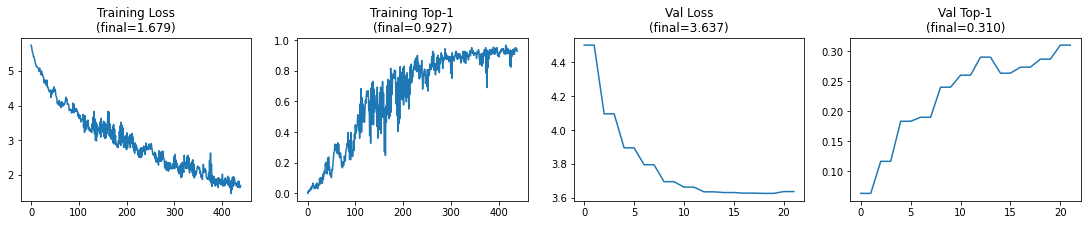

In [ ]:
# # Loading checkpoint  
ckpt_path = 'checkpoints/clip_image_vit_subj01_epoch10.pth'
checkpoint = torch.load(ckpt_path, map_location=device)
print(f"Plotting results from {ckpt_path}")
train_losses=checkpoint['train_losses']
train_topk=checkpoint['train_topk']
val_losses=checkpoint['val_losses']
val_topk=checkpoint['val_topk']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(19,3))
ax1.set_title(f"Training Loss\n(final={train_losses[-1]:.3f})")
ax1.plot(train_losses)
ax2.set_title(f"Training Top-1\n(final={train_topk[-1]:.3f})")
ax2.plot(train_topk)
ax3.set_title(f"Val Loss\n(final={val_losses[-1]:.3f})")
ax3.plot(val_losses)
ax4.set_title(f"Val Top-1\n(final={val_topk[-1]:.3f})")
ax4.plot(val_topk)
plt.show()

# Evaluation: Top-K Image Retrieval
Restart kernel and run all above cells excluding "Start model training"

In [ ]:
ckpt_path = 'checkpoints/clip_image_vit_subj01_epoch10.pth'
checkpoint = torch.load(ckpt_path, map_location=device)
brain_net.load_state_dict(checkpoint['model_state_dict'])
brain_net.eval()

CLIP IMG
fwd percent_correct tensor(0.1767, device='cuda:0')
bwd percent_correct tensor(0.2433, device='cuda:0')


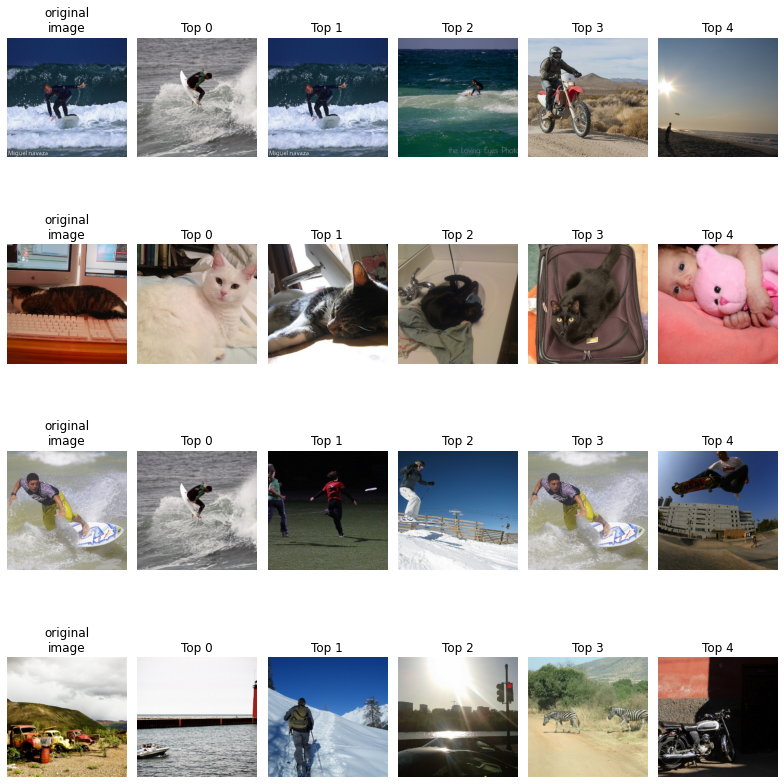

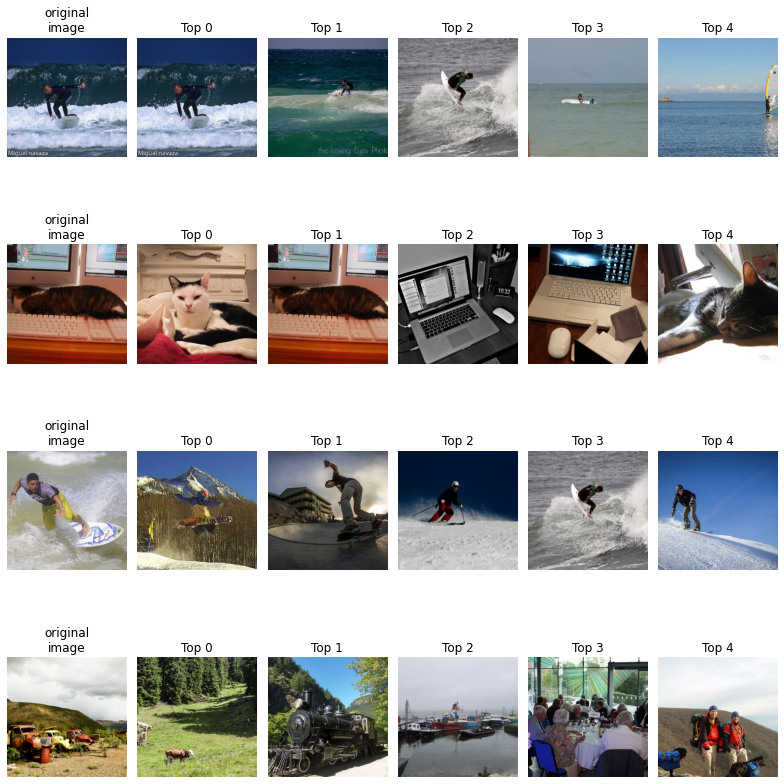

In [ ]:
minibatch = 10 # can use minibatches to be able to run evaluation on much weaker gpu
for val_i, (voxel, emb) in enumerate(val_dl):
    with torch.no_grad():
        voxel = voxel.to(device)
        
        with torch.cuda.amp.autocast():            
            for m in np.arange(0,batch_size,minibatch):
                if image_var=='images': # using images
                    if m==0:
                        emb0 = clip_extractor.embed_image(emb[m:m+minibatch])
                    else:
                        emb0 = torch.vstack((emb0,clip_extractor.embed_image(emb[m:m+minibatch])))
                else:
                    if m==0:
                        emb0 = clip_extractor.embed_curated_annotations(emb[m:m+minibatch])
                    else:
                        emb0 = torch.vstack((emb0,clip_extractor.embed_curated_annotations(emb[m:m+minibatch])))

        with torch.cuda.amp.autocast():
            emb_0 = nn.functional.normalize(brain_net(voxel),dim=-1)  # brain embeddings

        labels = torch.arange(len(emb0)).to(device)
        similarities0_bwd = batchwise_cosine_similarity(emb0,emb_0)  # clip, brain
        similarities0_fwd = batchwise_cosine_similarity(emb_0,emb0)  # brain, clip

        print("CLIP IMG")

        percent_correct_fwd = topk(similarities0_fwd, labels,k=1)
        print("fwd percent_correct", percent_correct_fwd)

        percent_correct_bwd = topk(similarities0_bwd, labels,k=1)
        print("bwd percent_correct", percent_correct_bwd)

        similarities0_fwd = np.array(similarities0_fwd.detach().cpu())
        fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
        for trial in range(4):
            ax[trial, 0].imshow(torch_to_Image(emb[trial]))
            ax[trial, 0].set_title("original\nimage")
            ax[trial, 0].axis("off")
            for attempt in range(5):
                which = np.flip(np.argsort(similarities0_fwd[trial]))[attempt]
                ax[trial, attempt+1].imshow(torch_to_Image(emb[which]))
                ax[trial, attempt+1].set_title(f"Top {attempt}")
                ax[trial, attempt+1].axis("off")
        fig.tight_layout()
        plt.show()

        similarities0_bwd = np.array(similarities0_bwd.detach().cpu())
        fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
        for trial in range(4):
            ax[trial, 0].imshow(torch_to_Image(emb[trial]))
            ax[trial, 0].set_title("original\nimage")
            ax[trial, 0].axis("off")
            for attempt in range(5):
                which = np.flip(np.argsort(similarities0_bwd[trial]))[attempt]
                ax[trial, attempt+1].imshow(torch_to_Image(emb[which]))
                ax[trial, attempt+1].set_title(f"Top {attempt}")
                ax[trial, attempt+1].axis("off")
        fig.tight_layout()
        plt.show()
    break # only doing 300 samples